In [1]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col,collect_list, to_timestamp, expr, regexp_replace,split, to_timestamp, from_unixtime,date_format,when,concat,lit,hour,minute,to_date
from pyspark.sql.types import StructType, StringType, StructField
import missingno as msno
import pandas as pd

In [2]:
spark = SparkSession.builder.appName('bovo').getOrCreate()

In [3]:
spark

In [4]:
schema = StructType([
    StructField("AreaCode", StringType(), False),
    StructField("Date", StringType(), False),
    StructField("Time", StringType(), False),
    StructField("Temperature(°F)", StringType(), False),
    StructField("DewPoint(°F)", StringType(), False),
    StructField("Humidity(%)", StringType(), False),
    StructField("Wind", StringType(), False),
    StructField("WindSpeed(mph)", StringType(), False),
    StructField("WindGust(mph)", StringType(), False),
    StructField("Pressure(in)", StringType(), False),
    StructField("Precip(in)", StringType(), False),
    StructField("Condition", StringType(), False)
    
    
    
])

In [5]:
folder_paths = [r'C:\Users\httyd\Desktop\Data\report_2020\*.csv', r'C:\Users\httyd\Desktop\Data\report_2021\*.csv']
df_pyspark=spark.read.option('header','true').csv(folder_paths ,inferSchema=True)
df_weather=spark.read.option('header','true').csv(r'C:\Users\httyd\Desktop\capstone\2020\*.csv',schema=schema)

In [6]:
df_pyspark.show(100)

+----+-------+-----+----------+---------+----------+-------------------------+---------------------------------------+------------------------+---------------------------+-------------------------------+---------------------------------------+----------------------------------------------+-------------------------------------------------+--------------------------------------------------+------------------+------------------------+---------------------------+-----------+-------------------------------+---------------+------------------+------------------+------+--------------------+-----------+---------------+---------------+---------+-------------+----------------+----------------+----+-------------+---------+-------------+--------------+-------+----------+-------+--------+---------------+--------+--------------------+----------+-------+---------+--------+------+----------+-------+--------+---------------+--------+------------------+----------+---------+----------------+--------+-----

In [7]:
# Define the list of specific texts you want to search for
airports = ["ATL", "CLT", "DEN", "DFW", "EWR", "IAH", "JFK", "LAS", "LAX", "MCO", "MIA", "ORD", "PHX", "SEA", "SFO"]  # Add your specific texts here
fields = ["Year",
          "Quarter",
          "Month",
          "DayofMonth",
          "FlightDate",
          "OriginAirportID",
          "Origin",
          "DestAirportID",
          "Dest",
          "CRSDepTime",
          "DepTime",
          "DepDelayMinutes",
          "DepDel15",
          "CRSArrTime",
          "ArrTime",
          "ArrDelayMinutes",
          "ArrDel15"]
# Filter DataFrame rows based on multiple specific texts in a particular column
df_pyspark = df_pyspark.filter(col("Origin").isin(airports))
df_pyspark = df_pyspark.filter(col("Dest").isin(airports))
# Select specific columns
df_pyspark = df_pyspark.select(fields)

# Show the filtered DataFrame
df_pyspark.show(100)

+----+-------+-----+----------+----------+---------------+------+-------------+----+----------+-------+---------------+--------+----------+-------+---------------+--------+
|Year|Quarter|Month|DayofMonth|FlightDate|OriginAirportID|Origin|DestAirportID|Dest|CRSDepTime|DepTime|DepDelayMinutes|DepDel15|CRSArrTime|ArrTime|ArrDelayMinutes|ArrDel15|
+----+-------+-----+----------+----------+---------------+------+-------------+----+----------+-------+---------------+--------+----------+-------+---------------+--------+
|2020|      1|    1|         1|2020-01-01|          12889|   LAS|        12478| JFK|       605|    556|            0.0|     0.0|      1351|   1335|            0.0|     0.0|
|2020|      1|    1|         2|2020-01-02|          12889|   LAS|        12478| JFK|       605|    605|            0.0|     0.0|      1351|   1354|            3.0|     0.0|
|2020|      1|    1|         3|2020-01-03|          12889|   LAS|        12478| JFK|       605|    558|            0.0|     0.0|      1

In [8]:
# Convert it to string with leading zeros if necessary
df_pyspark = df_pyspark.withColumn("CRSArrTime", col("CRSArrTime").cast("string"))

# Pad the string representation of time with leading zeros if necessary
df_pyspark = df_pyspark.withColumn("CRSArrTime", \
    expr("LPAD(CRSArrTime, 4, '0')"))

# Convert the 'CRSArrTime' column to timestamp format
df_pyspark = df_pyspark.withColumn("CRSArrTime", \
    to_timestamp(col("CRSArrTime"), "HHmm"))

split_col = split(df_pyspark['CRSArrTime'], ' ')
df_pyspark = df_pyspark.withColumn('CRSArrTime', split_col.getItem(1))  # Extract date component


# Show the DataFrame
df_pyspark.show(100)

+----+-------+-----+----------+----------+---------------+------+-------------+----+----------+-------+---------------+--------+----------+-------+---------------+--------+
|Year|Quarter|Month|DayofMonth|FlightDate|OriginAirportID|Origin|DestAirportID|Dest|CRSDepTime|DepTime|DepDelayMinutes|DepDel15|CRSArrTime|ArrTime|ArrDelayMinutes|ArrDel15|
+----+-------+-----+----------+----------+---------------+------+-------------+----+----------+-------+---------------+--------+----------+-------+---------------+--------+
|2020|      1|    1|         1|2020-01-01|          12889|   LAS|        12478| JFK|       605|    556|            0.0|     0.0|  13:51:00|   1335|            0.0|     0.0|
|2020|      1|    1|         2|2020-01-02|          12889|   LAS|        12478| JFK|       605|    605|            0.0|     0.0|  13:51:00|   1354|            3.0|     0.0|
|2020|      1|    1|         3|2020-01-03|          12889|   LAS|        12478| JFK|       605|    558|            0.0|     0.0|  13:51

In [9]:
# Add a new column 'rounded_hour' that represents the closest hour
df_pyspark = df_pyspark.withColumn("Newdate", to_date("CRSArrTime")) \
    .withColumn("hour", hour("CRSArrTime")) \
    .withColumn("minute", minute("CRSArrTime")) \
    .withColumn("rounded_hour",
                when(col("minute") >= 30, expr("hour + 1")).otherwise(col("hour"))
                ) \
    .withColumn("rounded_hour", when(col("rounded_hour") == 24, 0).otherwise(col("rounded_hour"))) \
    .withColumn("rounded_hour", 
                when(col("rounded_hour") == 0, 23)
                .otherwise(col("rounded_hour"))) \
    .withColumn("rounded_hour", concat(
        when(col("rounded_hour") < 10, concat(lit("0"), col("rounded_hour"))).otherwise(col("rounded_hour")),
        lit(":00:00"))) \
    .drop("hour", "minute", "Newdate")


In [10]:
# Drop rows with any null values
df_pyspark = df_pyspark.dropna()

Axes(0.125,0.11;0.698618x0.77)


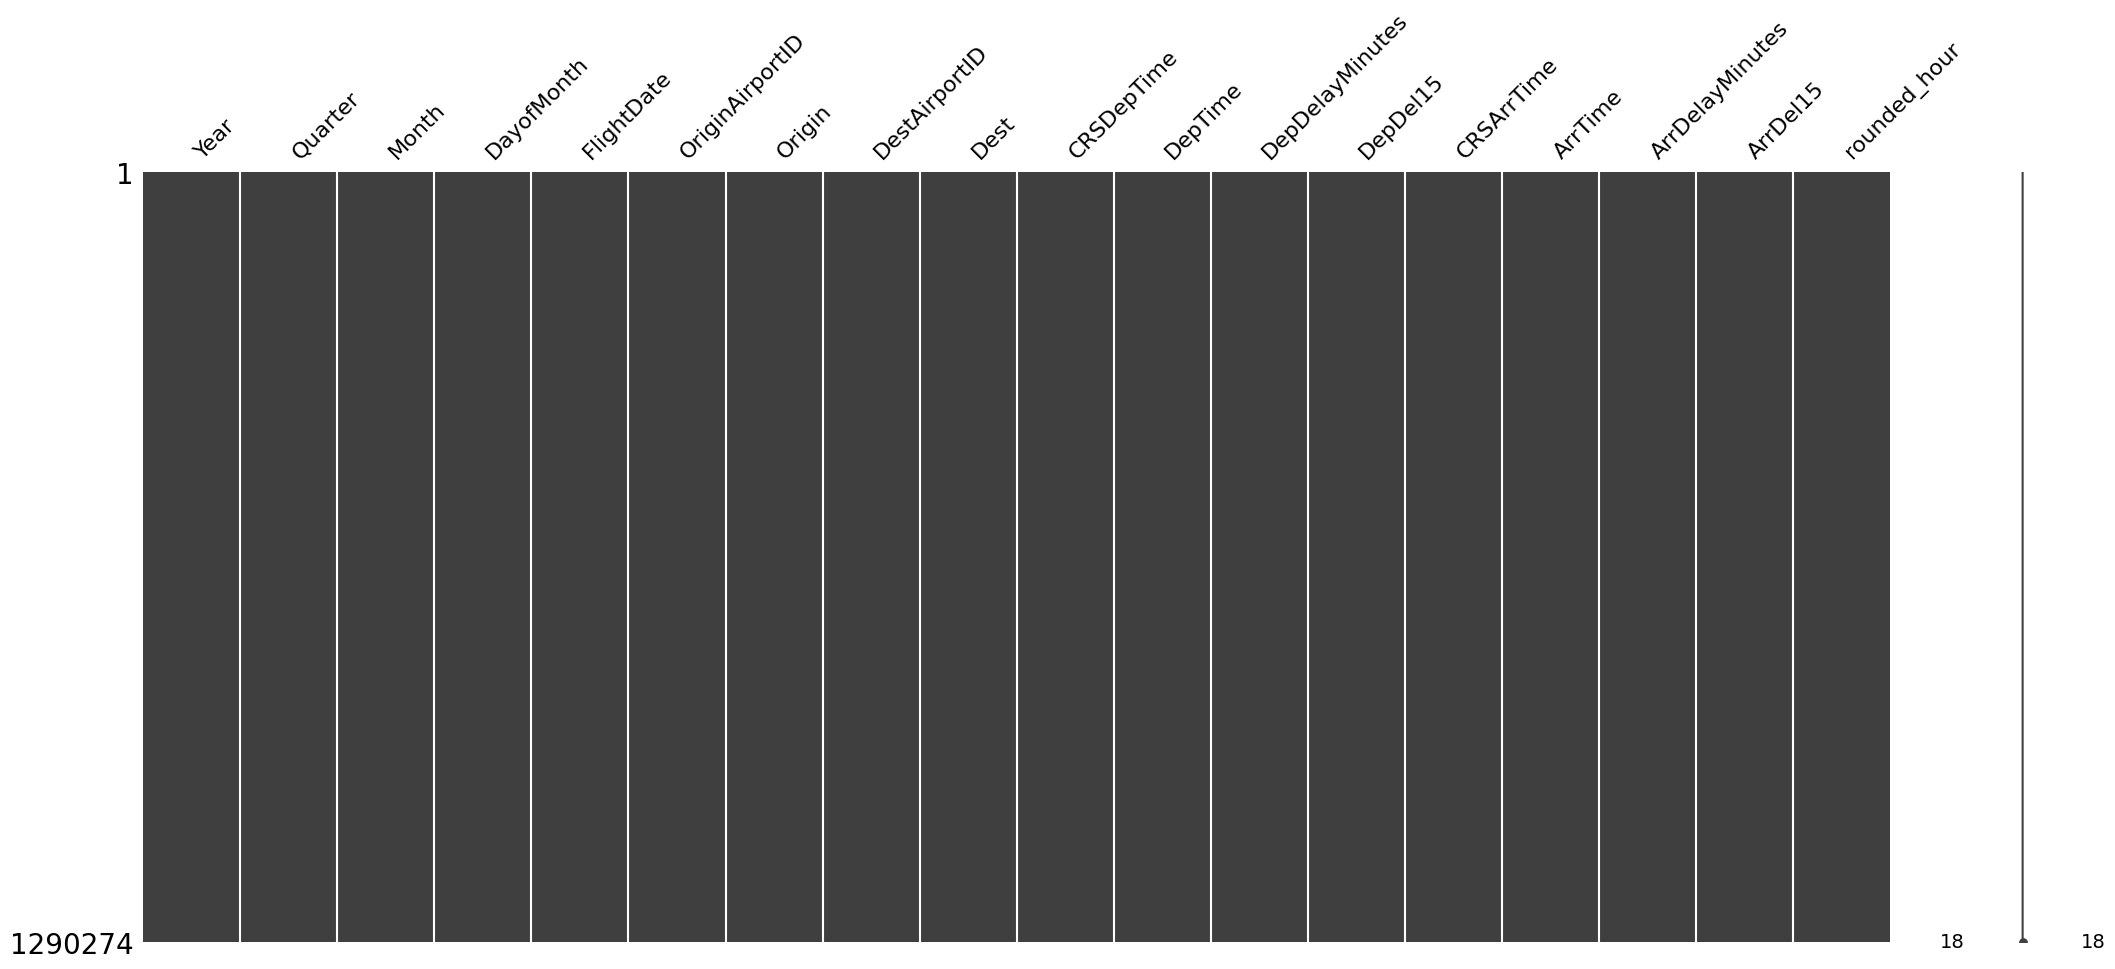

In [11]:
print(msno.matrix(df_pyspark.toPandas()))

In [12]:
# Assuming your DataFrame is named df_weather
df_weather = df_weather.withColumn("Time", date_format(to_timestamp("Time", "h:mm a"), "HH:mm"))

In [13]:
split_col = split(df_weather['Temperature(°F)'], '°')
df_weather = df_weather.withColumn('Temperature(°F)', split_col.getItem(0))  # Extract date component
split_col = split(df_weather['DewPoint(°F)'], '°F')
df_weather = df_weather.withColumn('DewPoint(°F)', split_col.getItem(0))  # Extract date component
split_col = split(df_weather['Humidity(%)'], '°%')
df_weather = df_weather.withColumn('Humidity(%)', split_col.getItem(0))  # Extract date component
split_col = split(df_weather['WindSpeed(mph)'], '°mph')
df_weather = df_weather.withColumn('WindSpeed(mph)', split_col.getItem(0))  # Extract date component
split_col = split(df_weather['WindGust(mph)'], '°mph')
df_weather = df_weather.withColumn('WindGust(mph)', split_col.getItem(0))  # Extract date component
split_col = split(df_weather['Pressure(in)'], '°in')
df_weather = df_weather.withColumn('Pressure(in)', split_col.getItem(0))  # Extract date component
split_col = split(df_weather['Precip(in)'], '°in')  # Use backticks to escape the dot
df_weather = df_weather.withColumn('Precip(in)', split_col.getItem(0))  # Extract date component

In [14]:
from pyspark.sql.functions import when

# Create a new column 'WindDirectionDegrees' to store the converted wind direction in degrees
df_weather = df_weather.withColumn("WindDir",
                   when(df_weather["Wind"] == "N", 0)
                   .when(df_weather["Wind"] == "NNE", 22.5)
                   .when(df_weather["Wind"] == "NE", 45)
                   .when(df_weather["Wind"] == "ENE", 67.5)
                   .when(df_weather["Wind"] == "E", 90)
                   .when(df_weather["Wind"] == "ESE", 112.5)
                   .when(df_weather["Wind"] == "SE", 135)
                   .when(df_weather["Wind"] == "SSE", 157.5)
                   .when(df_weather["Wind"] == "S", 180)
                   .when(df_weather["Wind"] == "SSW", 202.5)
                   .when(df_weather["Wind"] == "SW", 225)
                   .when(df_weather["Wind"] == "WSW", 247.5)
                   .when(df_weather["Wind"] == "W", 270)
                   .when(df_weather["Wind"] == "WNW", 292.5)
                   .when(df_weather["Wind"] == "NW", 315)
                   .when(df_weather["Wind"] == "NNW", 337.5)
                   .otherwise(None))


In [15]:
# Add a new column 'rounded_hour' that represents the closest hour
df_weather = df_weather.withColumn("Newdate", to_date("Time")) \
    .withColumn("hour", hour("Time")) \
    .withColumn("minute", minute("Time")) \
    .withColumn("Weatherrounded_hour",
                when(col("minute") >= 30, expr("hour + 1")).otherwise(col("hour"))
                ) \
    .withColumn("Weatherrounded_hour", when(col("Weatherrounded_hour") == 24, 0).otherwise(col("Weatherrounded_hour"))) \
    .withColumn("Weatherrounded_hour", 
                when(col("Weatherrounded_hour") == 0, 23)
                .otherwise(col("Weatherrounded_hour"))) \
    .withColumn("Weatherrounded_hour", concat(
        when(col("Weatherrounded_hour") < 10, concat(lit("0"), col("Weatherrounded_hour"))).otherwise(col("Weatherrounded_hour")),
        lit(":00:00"))) \
    .drop("hour", "minute", "Newdate", "Wind")

In [16]:
df_weather.show(100)

+--------+----------+-----+---------------+------------+-----------+--------------+-------------+------------+----------+---------------+-------+-------------------+
|AreaCode|      Date| Time|Temperature(°F)|DewPoint(°F)|Humidity(%)|WindSpeed(mph)|WindGust(mph)|Pressure(in)|Precip(in)|      Condition|WindDir|Weatherrounded_hour|
+--------+----------+-----+---------------+------------+-----------+--------------+-------------+------------+----------+---------------+-------+-------------------+
|     ATL|2021-01-01|02:52|            57 |         56 |        96 |           10 |           0 |      29.00 |      0.0 |     Light Rain|  112.5|           03:00:00|
|     ATL|2021-01-01|03:52|            58 |         57 |        97 |            9 |           0 |      28.98 |      0.0 |Drizzle and Fog|  112.5|           04:00:00|
|     ATL|2021-01-01|04:52|            58 |         57 |        97 |            9 |           0 |      28.97 |      0.0 |            Fog|  112.5|           05:00:00|
|   

In [17]:
df_weather = df_weather.dropna()

Axes(0.125,0.11;0.698618x0.77)


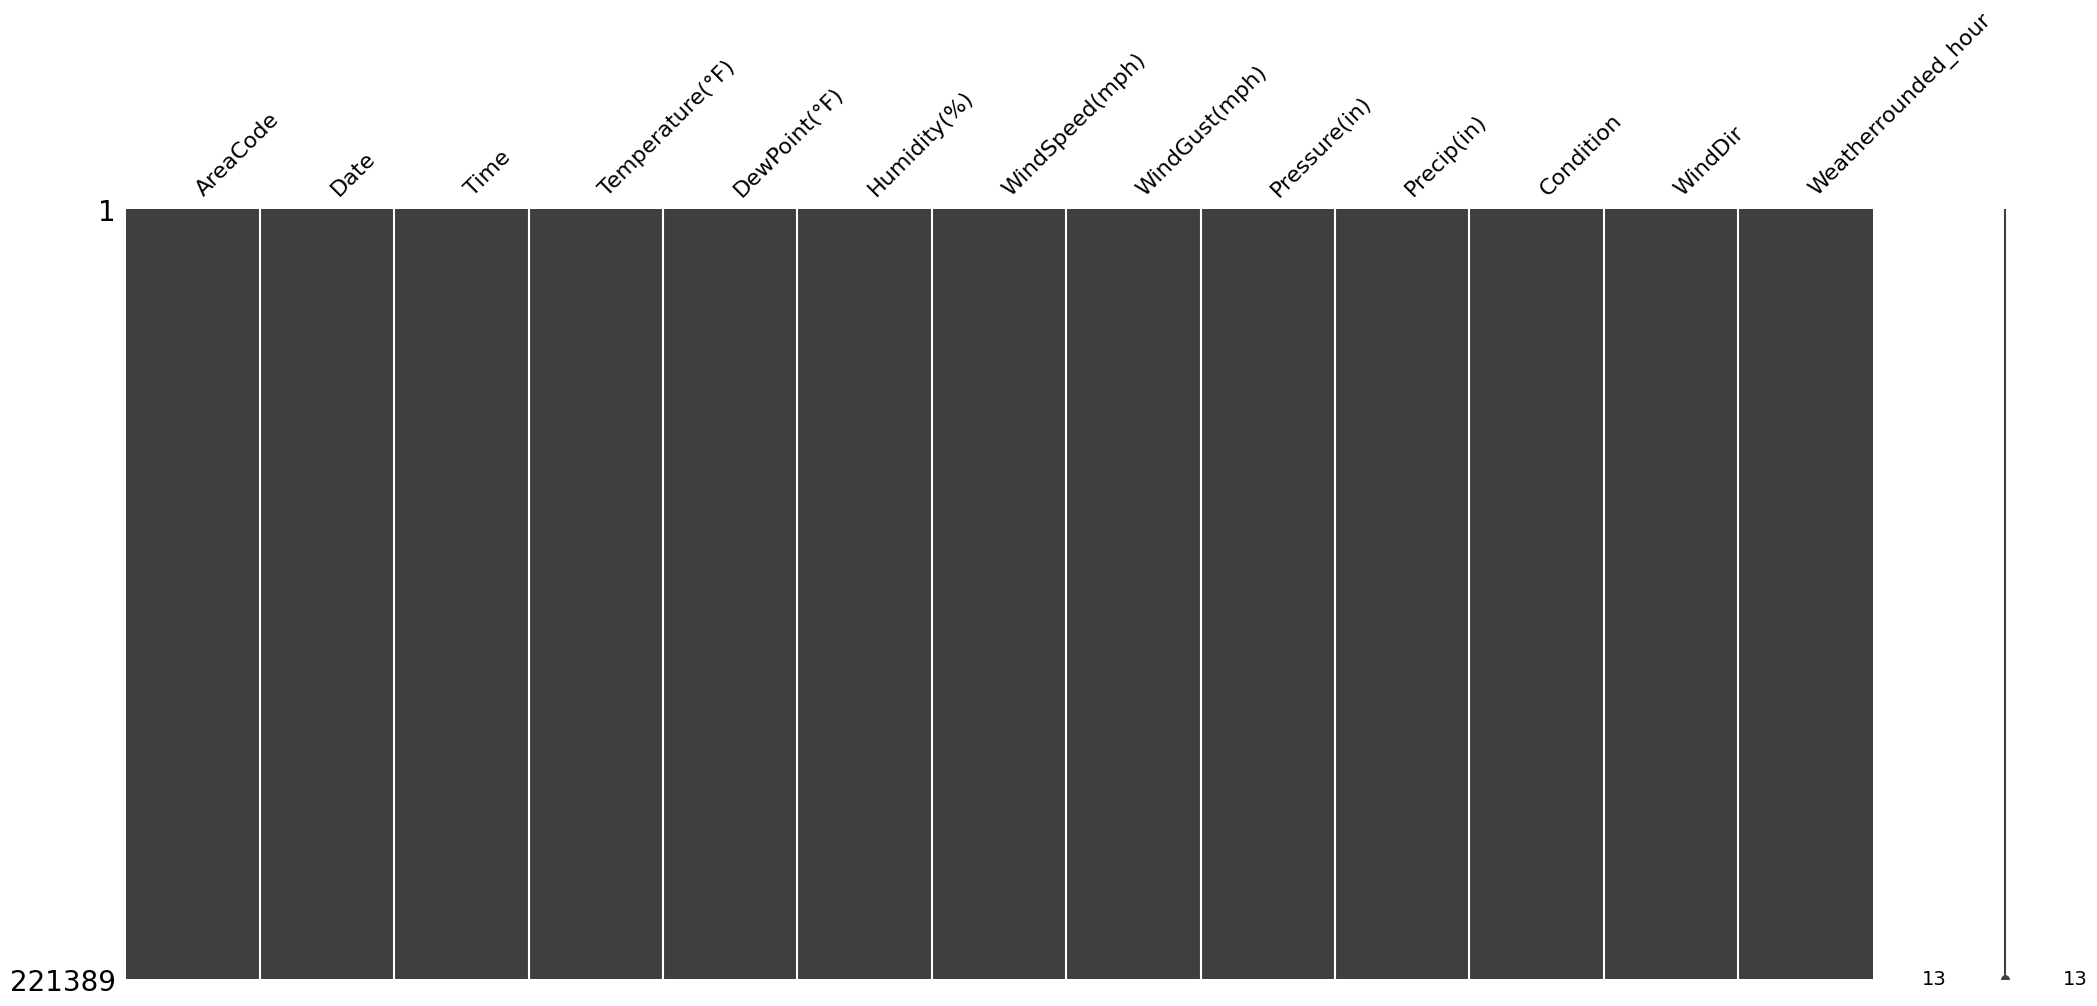

In [18]:
print(msno.matrix(df_weather.toPandas()))

In [19]:
# unique_names = df_pyspark.select("Origin").distinct().rdd.flatMap(lambda x: x).collect()

# # Print the unique values
# for name in unique_names:
#     print(name)

In [20]:
# Define the list of specific texts you want to search for
specific_texts = ["ATL", "CLT", "DEN", "DFW", "EWR", "IAH", "JFK", "LAS", "LAX", "MCO", "MIA", "ORD", "PHX", "SEA", "SFO"]  # Add your specific texts here

# Filter DataFrame rows based on multiple specific texts in a particular column
filtered_df = df_pyspark.filter(col("Origin").isin(specific_texts))

# Show the filtered DataFrame
filtered_df.show(100)

+----+-------+-----+----------+----------+---------------+------+-------------+----+----------+-------+---------------+--------+----------+-------+---------------+--------+------------+
|Year|Quarter|Month|DayofMonth|FlightDate|OriginAirportID|Origin|DestAirportID|Dest|CRSDepTime|DepTime|DepDelayMinutes|DepDel15|CRSArrTime|ArrTime|ArrDelayMinutes|ArrDel15|rounded_hour|
+----+-------+-----+----------+----------+---------------+------+-------------+----+----------+-------+---------------+--------+----------+-------+---------------+--------+------------+
|2020|      1|    1|         1|2020-01-01|          12889|   LAS|        12478| JFK|       605|    556|            0.0|     0.0|  13:51:00|   1335|            0.0|     0.0|    14:00:00|
|2020|      1|    1|         2|2020-01-02|          12889|   LAS|        12478| JFK|       605|    605|            0.0|     0.0|  13:51:00|   1354|            3.0|     0.0|    14:00:00|
|2020|      1|    1|         3|2020-01-03|          12889|   LAS|     

In [21]:
 # Join df_Arr and df_weather based on Newdate and rounded_date
joined_df_dep = filtered_df.join(df_weather, (filtered_df.rounded_hour == df_weather.Weatherrounded_hour)& (filtered_df.FlightDate == df_weather.Date)& (filtered_df.Dest == df_weather.AreaCode), "inner")
joined_df_dep.show(1000)

+----+-------+-----+----------+----------+---------------+------+-------------+----+----------+-------+---------------+--------+----------+-------+---------------+--------+------------+--------+----------+-----+---------------+------------+-----------+--------------+-------------+------------+----------+--------------------+-------+-------------------+
|Year|Quarter|Month|DayofMonth|FlightDate|OriginAirportID|Origin|DestAirportID|Dest|CRSDepTime|DepTime|DepDelayMinutes|DepDel15|CRSArrTime|ArrTime|ArrDelayMinutes|ArrDel15|rounded_hour|AreaCode|      Date| Time|Temperature(°F)|DewPoint(°F)|Humidity(%)|WindSpeed(mph)|WindGust(mph)|Pressure(in)|Precip(in)|           Condition|WindDir|Weatherrounded_hour|
+----+-------+-----+----------+----------+---------------+------+-------------+----+----------+-------+---------------+--------+----------+-------+---------------+--------+------------+--------+----------+-----+---------------+------------+-----------+--------------+-------------+---------

Axes(0.125,0.11;0.698618x0.77)
Year                   0
Quarter                0
Month                  0
DayofMonth             0
FlightDate             0
OriginAirportID        0
Origin                 0
DestAirportID          0
Dest                   0
CRSDepTime             0
DepTime                0
DepDelayMinutes        0
DepDel15               0
CRSArrTime             0
ArrTime                0
ArrDelayMinutes        0
ArrDel15               0
rounded_hour           0
AreaCode               0
Date                   0
Time                   0
Temperature(°F)        0
DewPoint(°F)           0
Humidity(%)            0
WindSpeed(mph)         0
WindGust(mph)          0
Pressure(in)           0
Precip(in)             0
Condition              0
WindDir                0
Weatherrounded_hour    0
dtype: int64


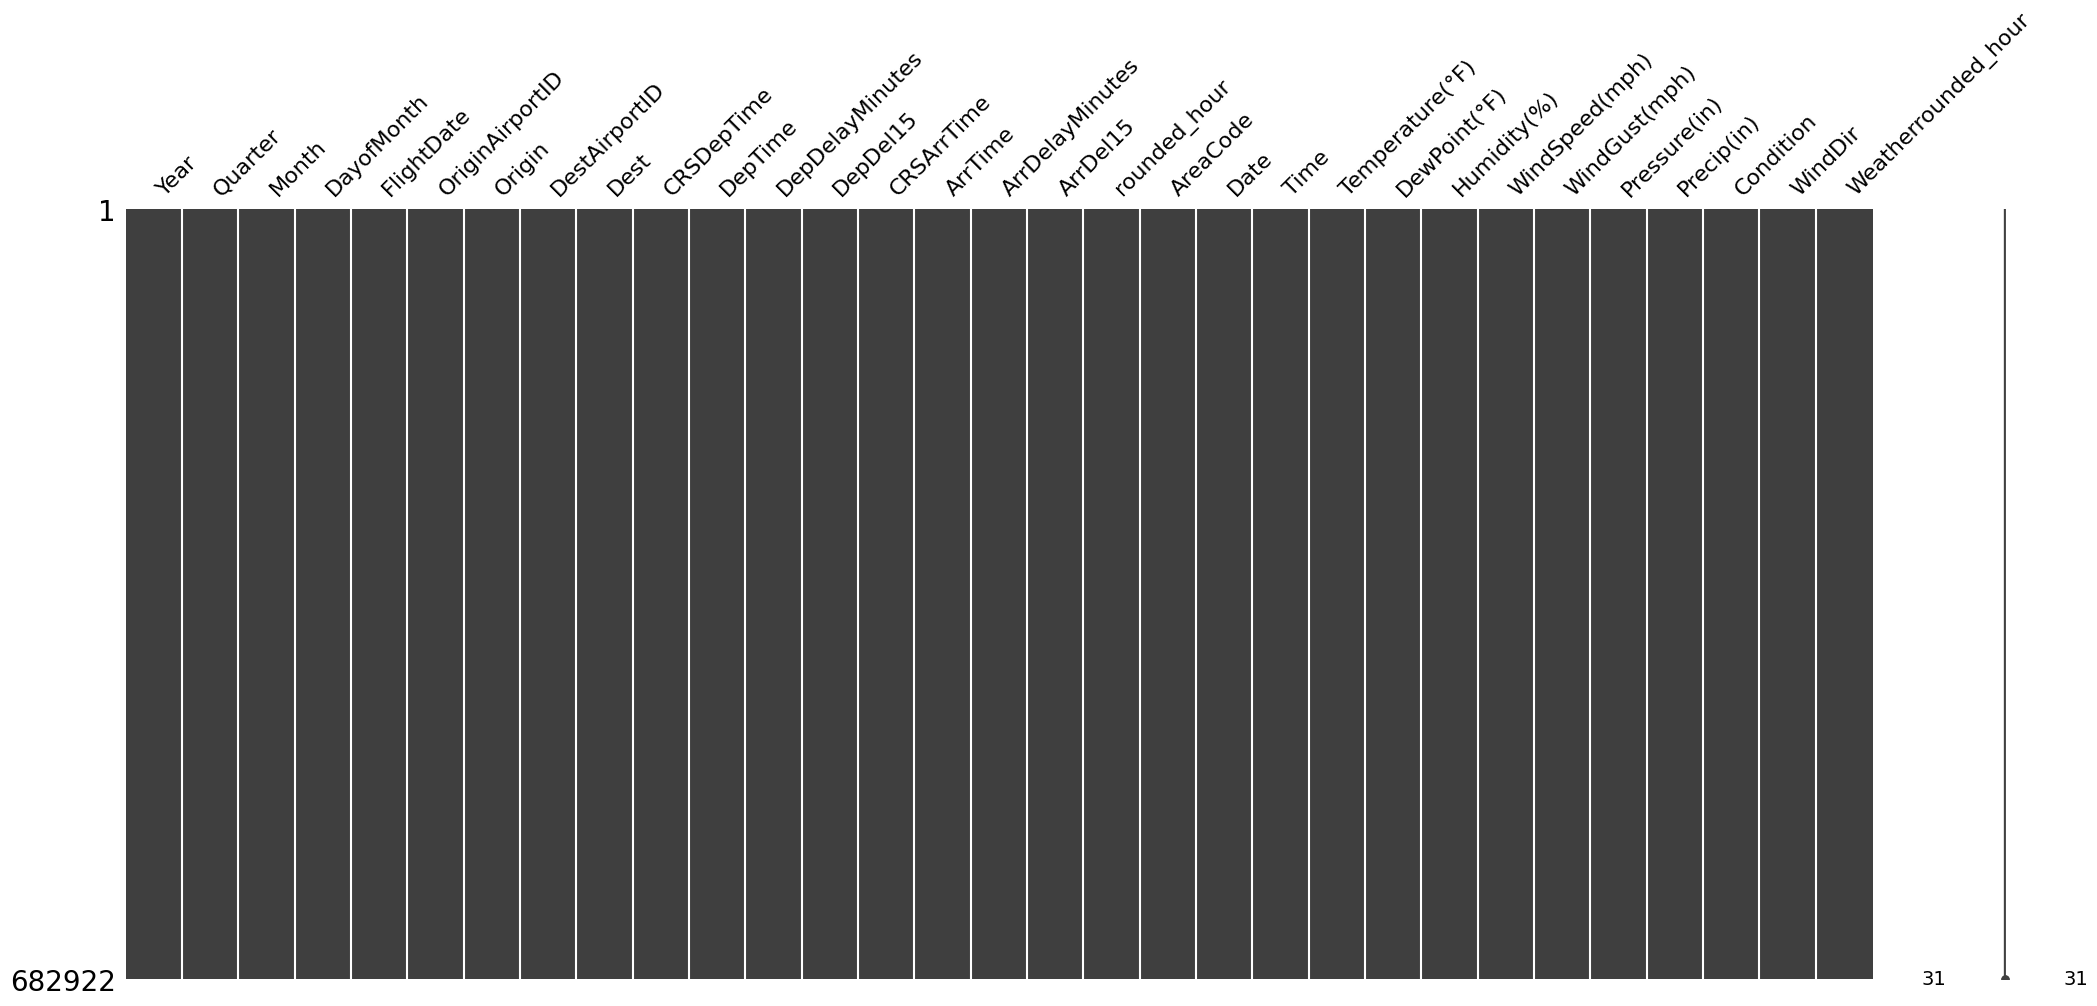

In [22]:
print(msno.matrix(joined_df_dep.toPandas()))
print(joined_df_dep.toPandas().isnull().sum())

In [25]:
# Repartition the DataFrame into a single partition
joined_df_dep = joined_df_dep.coalesce(1)
# Assuming df is your DataFrame
joined_df_dep.write.csv(r"C:\Users\httyd\Desktop\capstone\Data", header=True)


In [ ]:
# # Assuming df is your DataFrame
# row_count = filtered_df.count()

# # Print the number of rows
# print("Number of rows in the DataFrame:", row_count)
